Swift Data Analysis:  
+ Guide to Swift data processing and analysis: [link](https://www.swift.ac.uk/analysis/)
+ The SWIFT XRT Data Reduction Guide: [Link](https://swift.gsfc.nasa.gov/analysis/xrt_swguide_v1_2.pdf)

## 1. Module Imports

In [61]:
import os
import sys
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, LogLocator
import subprocess
from astropy.io import fits
from astropy.table import Table

Setting up observation parameters and creating the output directory.

In [62]:
obsid = "00035905082"
ra = 133.703646
dec = 20.108511
indir  = obsid
outdir = f"{obsid}_OP"

os.makedirs(outdir, exist_ok=True)

## 2. XRT PIPELINE

This section prepares and runs the `xrtpipeline` tool, which is part of the HEASoft suite and automates the entire data reduction workflow for the Swift X-ray Telescope (XRT). It processes raw Level 1 data files and outputs cleaned and calibrated Level 2 data products (event files, spectra, light curves, images, etc.) ready for scientific analysis.  
The pipeline consists of three logical stages:
1. Preprocessing and Calibration: This stage handles the preparation and calibration of raw XRT event files and housekeeping (HK) data.
2. Screening of Events: This stage filters the calibrated events based on quality and observational parameters. The result is a clean Level 2 event file, filtered and scientifically reliable.
3. Scientific Product Generation: This final stage uses the filtered data to generate science-ready products. 


The command is built as a list of arguments, which can later be executed using Python’s `subprocess.run()`. 

The `xrtpipeline` runs with the following arguments:  
+ `indir`: Specifies the input directory containing the raw observation data. Typically, this is a folder extracted from the Swift data archive.
+ `steminputs`: This defines the base filename stem used in the raw data files. For Swift, it's usually sw followed by the observation ID.
+ `outdir`: The directory where all processed (cleaned) output files will be saved.
+ `srcra`: Right Ascension (RA) of the source in decimal degrees. This is used to center and align data products.
+ `srcdec`: Declination (Dec) of the source in decimal degrees. Like RA, it ensures the data is aligned to the correct sky position.
+ `createexpomap`:  Instructs the pipeline to generate an exposure map, which is essential for accurate flux estimation.
+ `cleanup`: Automatically removes temporary and intermediate files created during processing to save space.
+ `clobber`: Allows overwriting of existing output files without prompting.

For more detailed information and advanced usage, you can refer to the official [xrtpipeline help documentation](https://heasarc.gsfc.nasa.gov/lheasoft/help/xrtpipeline.html).

In [93]:
xrt_cmd = [
    "xrtpipeline",
    f"indir={indir}",
    f"steminputs=sw{obsid}",
    f"outdir={outdir}",
    f"srcra={ra}",
    f"srcdec={dec}",
    "createexpomap=yes",
    "cleanup=yes",
    "clobber=yes"
]

# # Run the command and redirect output to a log file
# with open("xrtpipeline.log", "w") as logfile:
#     subprocess.run(xrt_cmd, stdout=logfile, stderr=subprocess.STDOUT)

xrt_cmd_str = " ".join(xrt_cmd)
print(xrt_cmd_str)

xrtpipeline indir=00035905082 steminputs=sw00035905082 outdir=00035905082_OP srcra=133.703646 srcdec=20.108511 createexpomap=yes cleanup=yes clobber=yes


## 3. XSELECT

`XSELECT` is a command-line interface tool that is part of the FTOOLS software suite, widely used in X-ray astrophysics data analysis. It provides a versatile environment for handling, filtering, and extracting scientific products from X-ray observational data. XSELECT supports many X-ray missions, including Swift (XRT and UVOT), Chandra, XMM-Newton, Suzaku, and others. [Learn more](https://heasarc.gsfc.nasa.gov/docs/software/ftools/xselect/xsel.html)

Here, `XSELECT` is used to generate light curves and spectra from Swift XRT observation. 

The cleaned event file is essential for generating scientific products. It contains X-ray photon events that have passed through all the necessary screening and calibration processes. This file serves as the primary input for scientific analyses such as creating light curves, spectra, or images. 

In this step, we are locating the cleaned event file.

In [89]:
cl_evt_files = glob.glob(os.path.join(outdir, "*xpcw3po_cl.evt"))[0]
cl_evt_file = os.path.basename(cl_evt_files)
cl_evt_file

'sw00035905082xpcw3po_cl.evt'

### 3.1 Lightcurve

We are preparing commands to run `XSELECT` for generating the light curve of the observation.

In [69]:
xselect_lc_cmd = f"""
xsel
read event {cl_evt_file}
{outdir}
yes
set binsize 10
extract all
save all lightcurve
exit
no
"""

print(" \n".join(line.strip() for line in xselect_lc_cmd.strip().splitlines()))

xsel 
read event sw00035905082xpcw3po_cl.evt 
00035905082_OP 
yes 
set binsize 10 
extract all 
save all lightcurve 
exit 
no


You can automate `XSELECT` by preparing a sequence of commands as a multiline string (or saving them into a file) and then passing them as input to the `XSELECT` process.

In [70]:
lc_process = subprocess.run(["bash", "-c", "xselect"], input=xselect_lc_cmd, text=True)

 
                         **  XSELECT V2.5c  **
 
> Enter session name >[xsel12436] 
xsel12436:XRISM > xsel
 Command not found; type ? for a command listing
xsel12436:XRISM > read event sw00035905082xpcw3po_cl.evt
> Enter the Event file dir >[00035905082_OP] 00035905082_OP
Got new mission: SWIFT
> Reset the mission ? >[yes] yes
 
 
        OBJECT      OBS_ID      DATE-OBS                 DATAMODE
      1 OJ287       00035905082 2020-06-05T08:55:17.5842 PHOTON
 
 Notes: XSELECT set up for      SWIFT
 Time keyword is TIME       in units of s
 Default timing binsize =   5.0000
 
Setting...
 Image  keywords   = X          Y           with binning =    1
 WMAP   keywords   = X          Y           with binning =    1
 Energy keyword   = PI                     with binning =    1
 
Getting Min and Max for Energy Column...
Got min and max for PI:     0   1023
 
Got the minimum time resolution of the read data:   2.5073
MJDREF =  5.1910000742870E+04 with TIMESYS = TT
 Number of files read in:

Tidying up by moving all XSELECT-generated lightcurve files and the log file into a dedicated folder.

In [71]:
lcdir = f"{obsid}_LC"
os.makedirs(lcdir, exist_ok=True)

for file in glob.glob("lightcurve*"):
    shutil.move(file, lcdir)

logfile = "xselect.log"
if os.path.isfile(logfile):
    shutil.move(logfile, lcdir)

Now, let’s examine the lightcurve file, `lightcurve.lc`, which contains the extracted timing data for the observation. 

This FITS file consists of multiple Header/Data Units (`HDUs`), including: 
1. `PRIMARY`: The main header with metadata about the file.
2. `RATE`: A binary table containing the actual lightcurve data.
3. `GTI`: The Good Time Intervals (GTI) during which the data is considered reliable and free from interruptions or instrumental issues.

We focus on the `RATE` table, which contains the measured count rates and associated information. This table has four columns:
+ `TIME`: The start time of each bin in seconds relative to the beginning of the observation.
+ `RATE`: The observed count rate (counts per second) in that time bin, representing the brightness of the source.
+ `ERROR`: The statistical uncertainty in the count rate, reflecting the measurement error.
+ `FRACEXP`: The fractional exposure time, indicating the portion of the time bin during which the detector was actively collecting data (ranges from 0 to 1).

The `GTI` table lists time intervals when the data is valid and uncontaminated by instrumental effects or observational gaps. These intervals ensure that the analysis only uses high-quality data.

In [72]:
lc_file = f"{lcdir}/lightcurve.lc"

with fits.open(lc_file) as hdul:
    hdul.info() # Print info about all HDUs
    rate_hdu = hdul[1]
    rate_table = Table(rate_hdu.data)
print(rate_table)

Filename: 00035905082_LC/lightcurve.lc
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     756   ()      
  1  RATE          1 BinTableHDU    693   104R x 4C   [D, E, E, E]   
  2  GTI           1 BinTableHDU     55   1R x 2C   [1D, 1D]   
 TIME     RATE     ERROR    FRACEXP
------ --------- ---------- -------
   0.0       0.7 0.26457512     1.0
  10.0       0.6 0.24494898     1.0
  20.0       0.1        0.1     1.0
  30.0       0.5  0.2236068     1.0
  40.0       0.2 0.14142135     1.0
  50.0       0.6 0.24494898     1.0
  60.0       0.3 0.17320508     1.0
  70.0       0.5  0.2236068     1.0
  80.0       0.4        0.2     1.0
  90.0       0.9        0.3     1.0
   ...       ...        ...     ...
 940.0       0.3 0.17320508     1.0
 950.0       0.6 0.24494898     1.0
 960.0       0.7 0.26457512     1.0
 970.0       0.6 0.24494898     1.0
 980.0       0.7 0.26457512     1.0
 990.0       0.4        0.2     1.0
1000.0       1.1 0.33166248   

Now, let’s plot the lightcurve to visualize the source’s brightness variation over time.

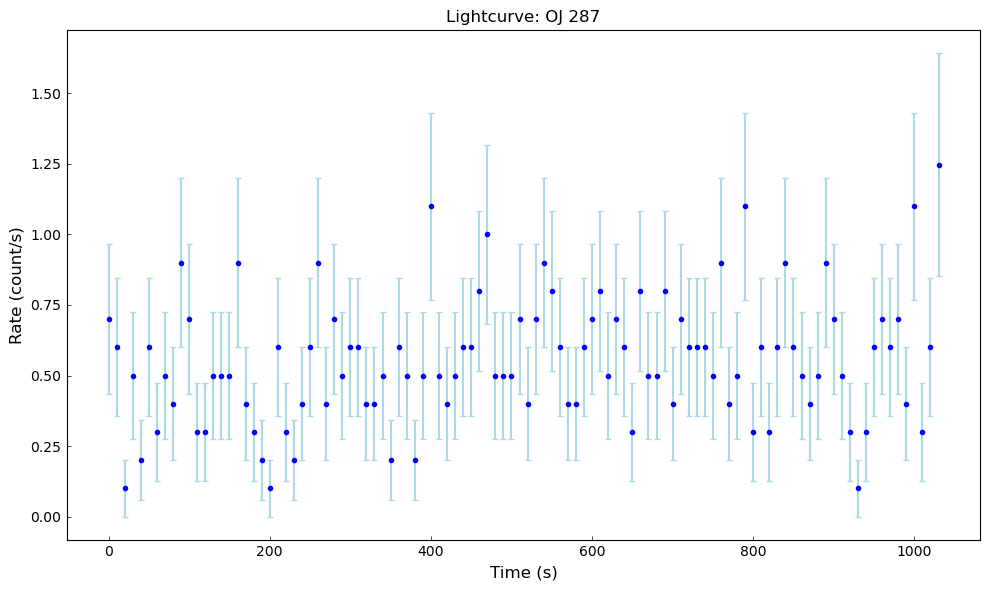

In [79]:
time = rate_table['TIME']
rate = rate_table['RATE']
error = rate_table['ERROR']

plt.figure(figsize=(10, 6))
plt.errorbar(time, rate, yerr=error, fmt='o', markersize=3, color='blue', ecolor='lightblue', capsize=2)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Rate (count/s)', fontsize=12)
plt.title('Lightcurve: OJ 287')
plt.tick_params(axis="both", direction="in", length=3, width=0.5, colors="black", pad=4, which="both", labelsize=10)
plt.tight_layout()
plt.show()

### 3.2 Spectrum

To generate the spectrum, we first need to create region files for both the source and the background using the `DS9` software.

**SAOImageDS9** is a astronomical imaging and data visualization tool widely used by astronomers. It allows users to display and analyze FITS images, create and edit region files, overlay multiple datasets, and perform various interactive operations. DS9 supports advanced features such as coordinate grids, scaling, color maps, and region-based filtering, making it an essential tool for preparing and inspecting data before further analysis like spectral extraction. [Learn more](https://sites.google.com/cfa.harvard.edu/saoimageds9)

Let's make regions files here in python and verify it in DS9.

In [84]:
# write region files
region = """# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
circle(133.7036000,20.1085000,40.000") # text={src}
"""
with open('src.reg', 'w') as fp: fp.write(region)

region = """# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
circle(133.6291073,20.0514248,100.000") # text={bkg}
"""
with open('bkg.reg', 'w') as fp: fp.write(region)

We are preparing commands to run `XSELECT` for generating the spectrum of the observation.

In [87]:
xselect_spec_cmd = f"""
xsel
read event {cl_evt_file}
{outdir}
yes
extract image
filter region src.reg
extract spectrum
save spectrum spec.pi
clear region
filter region bkg.reg
extract spectrum
save spectrum spec_bkg.pi
exit
no
"""

print(" \n".join(line.strip() for line in xselect_spec_cmd.strip().splitlines()))

xsel 
read event sw00035905082xpcw3po_cl.evt 
00035905082_OP 
yes 
extract image 
filter region src.reg 
extract spectrum 
save spectrum spec.pi 
clear region 
filter region bkg.reg 
extract spectrum 
save spectrum spec_bkg.pi 
exit 
no


In [88]:
spec_process = subprocess.run(["bash", "-c", "xselect"], input=xselect_spec_cmd, text=True)

 
                         **  XSELECT V2.5c  **
 
> Enter session name >[xsel12436] 
xsel12436:XRISM > xsel
 Command not found; type ? for a command listing
xsel12436:XRISM > read event sw00035905082xpcw3po_cl.evt
> Enter the Event file dir >[00035905082_OP] 00035905082_OP
Got new mission: SWIFT
> Reset the mission ? >[yes] yes
 
 
        OBJECT      OBS_ID      DATE-OBS                 DATAMODE
      1 OJ287       00035905082 2020-06-05T08:55:17.5842 PHOTON
 
 Notes: XSELECT set up for      SWIFT
 Time keyword is TIME       in units of s
 Default timing binsize =   5.0000
 
Setting...
 Image  keywords   = X          Y           with binning =    1
 WMAP   keywords   = X          Y           with binning =    1
 Energy keyword   = PI                     with binning =    1
 
Getting Min and Max for Energy Column...
Got min and max for PI:     0   1023
 
Got the minimum time resolution of the read data:   2.5073
MJDREF =  5.1910000742870E+04 with TIMESYS = TT
 Number of files read in:

In this step, we are locating the Exposure map file.

This file stores exposure maps, which quantify how much time each pixel was exposed during the observation. It’s critical for image and spectral analysis to correct for instrumental effects like vignetting or bad pixels.

In [107]:
ex_img_files = glob.glob(os.path.join(outdir, "*xpcw3po_ex.img"))[0]
ex_img_files

'00035905082_OP/sw00035905082xpcw3po_ex.img'

In [111]:
arf_cmd = [
    "xrtmkarf",
    "outfile=spec.arf",
    "phafile=spec.pi",
    f"expofile={ex_img_files}",
    "srcx=-1",
    "srcy=-1",
    "psfflag=yes",
    "cleanup=yes",
    "clobber=yes"
]

arf_cmd_str = " ".join(arf_cmd)
print(arf_cmd_str)

xrtmkarf outfile=spec.arf phafile=spec.pi expofile=00035905082_OP/sw00035905082xpcw3po_ex.img srcx=-1 srcy=-1 psfflag=yes cleanup=yes clobber=yes


In [115]:
pha_file = "spec.pi"
with fits.open(pha_file, mode='update') as hdul:
    hdr = hdul[1].header
    hdr['BACKFILE'] = 'spec_bkg.pi'
    hdr['ANCRFILE'] = 'spec.arf'
    hdr['RESPFILE'] = 'rspdata/swxpc0to12s6_20010101v011.rmf'
    hdul.flush()

In [116]:
import os 
import sys
import numpy as np
import pandas as pd
from xspec import *


# pha = "spec.pi"

ch = Xset.chatter
Xset.chatter = 20
lch = Xset.logChatter
Xset.logChatter = 20
logFile = Xset.openLog("xspec.log")
logFile = Xset.log

s1 = Spectrum("spec.pi")
s1.response = "rspdata/swxpc0to12s6_20010101v011.rmf"
s1.response.arf = "spec.arf"
s1.background = "spec_bkg.pi"
AllData.ignore("bad")
s1.ignore("**-0.3,10.0-**")

m1 = Model("tbabs*powerlaw")
m1.TBabs.nH = 0.0237
m1.TBabs.nH.frozen = True
m1.powerlaw.PhoIndex = 1.0
Fit.nIterations = 100
Fit.statMethod = "chi"
Fit.perform()
Fit.show()

AllModels.calcFlux("0.3 10.0 err")

Plot.device = f"plot.ps"
Plot.xAxis = "Hz"
Plot.xLog = True
Plot.yLog = True
Plot.setRebin(20, 20)
Plot("eeufspec","ratio")

Plot.device = "/null"
Plot("eeufspec")
xVals = Plot.x()
yVals = Plot.y()
modVals = Plot.model()
yErrs = Plot.yErr()
dataM = np.column_stack((xVals, yVals, yErrs, modVals))
np.savetxt("spec.csv", dataM, delimiter=",", header="xVals,yVals,yErrs,modVals", comments="")
Plot("ratio")
xVals = Plot.x()
yVals = Plot.y()
yErrs = Plot.yErr()
dataR = np.column_stack((xVals, yVals, yErrs))
np.savetxt("ratio.csv", dataR, delimiter=",", header="xVals,yVals,yErrs", comments="")

AllData.clear()
Xset.closeLog()

Logging to file: xspec.log
***Warning: Detected response matrix energy = 0 for the lower edge of bin 0
     XSPEC will instead use 5e-06 (response file will not be altered)

1 spectrum  in use
 
Spectral Data File: spec.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.063e-01 +/- 1.722e-02 (99.9 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-1024
  Telescope: SWIFT Instrument: XRT  Channel Type: PI
  Exposure Time: 1034 sec
 Using fit statistic: chi
 Using Background File                spec_bkg.pi
  Background Exposure Time: 1034 sec
 Using Response (RMF) File            rspdata/swxpc0to12s6_20010101v011.rmf for Source 1
 Using Auxiliary Response (ARF) File  spec.arf
 Grouping data :
   1024 channels grouped to 1024
        1 ++++++++++++++++++++++++++++++++++++++++++++++++++
       51 ++++++++++++++++++++++++++++++++++++++++++++++++++
      101 ++++++++++++++++++++++++++++++++++++++++++++++++++
      151 +++++++++++++++++++++++++++++++++++++++++++++

***Warning: Ill-formed Fit problem - number of variable parameters exceeds number of bins


Exception: Error executing command: fit

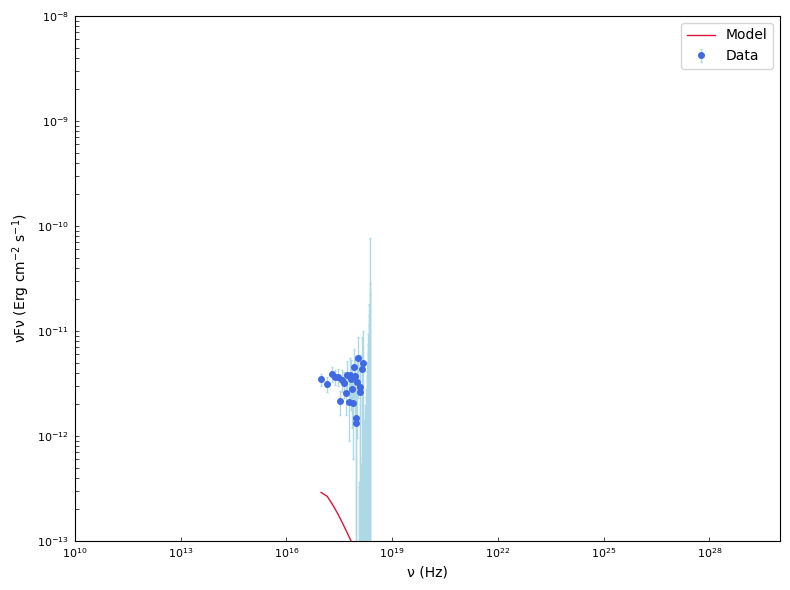

In [114]:
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, LogLocator

phapath = os.getcwd()

scsv = os.path.join(phapath, "spec.csv")
df_spect = pd.read_csv(scsv)
x1, y1, y1e, mdl = df_spect["xVals"], df_spect["yVals"], df_spect["yErrs"], df_spect["modVals"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(x1, y1, yerr=y1e, fmt="o", markersize=4, label="Data", color="royalblue", ecolor="lightblue", elinewidth=1, capsize=1)
ax.plot(x1, mdl, label="Model", color="crimson", linestyle="-", linewidth=1)
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e10, 1e30)
ax.set_ylim(1e-13, 1e-8) 
ax.set_xlabel('ν (Hz)')
ax.set_ylabel(r'νFν (Erg cm$^{-2}$ s$^{-1}$)')
ax.tick_params(axis="both", direction="in", length=3, width=0.5, colors="black", pad=4, which="both", labelsize=8)
plt.tight_layout()
plt.savefig(f"{phapath}/spec.png", dpi=300, bbox_inches="tight")
plt.show()